In [1]:
import os
os.environ['PYSR_AUTOLOAD_EXTENSIONS'] = 'no'
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from brokenaxes import brokenaxes
from interpret import paretoize, overall_complexity
%matplotlib inline

/home/sca63/.conda/envs/bnn_new_pysr/lib/python3.7/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  "torch was imported before juliacall. This may cause a segfault. "


In [2]:
version = 11003
results_path = f'sr_results/{version}.pkl'
reg = pickle.load(open(results_path, 'rb'))
results = reg.equations_[0]

In [3]:
k_results = pickle.load(open('pickles/k_results_train.pkl', 'rb'))
k_results_test = pickle.load(open('pickles/k_results_test.pkl', 'rb'))

In [4]:
d = {2: {'version': 24880,
         'pysr_version': 11003},
        #  'complexities': [1, 3, 5, 7, 9, 11, 14, 20, 29, 30]},
     3: {'version': 74649,
         'pysr_version': 83278},
        #  'complexities': [1, 3, 5, 7, 9, 13, 19, 35, 52, 60]},
     4: {'version': 11566,
         'pysr_version': 51254},
        #  'complexities': [1, 3, 5, 7, 10, 12, 16, 23, 56, 60]},
     5: {'version': 72646,
         'pysr_version': 55894}}
        #  'complexities': [1, 3, 5, 7, 11, 19, 27, 40, 59]}}

In [5]:
# goal is to have a table with k, complexity, loss, overall_rmse, overall_complexity
# 1. for each k, load the original PySR table
# 2. get rid of columns except for complexity and loss
# 3. filter to just the important complexities
# 4. for each important complexity, get the overall complexity and rmse
# k_results is a dict mapping k to a dict mapping an important complexity to rmse

k_tables = {}
for k, v in d.items():
    # load the original PySR table
    pysr_version = v['pysr_version']
    results_path = f'sr_results/{pysr_version}.pkl'
    reg = pickle.load(open(results_path, 'rb'))
    results = reg.equations_[0]

    results['overall_complexity'] = results.apply(lambda x: overall_complexity(x, k), axis=1)
    results['rmse'] = results.apply(lambda x: k_results_test[k][x['complexity']], axis=1)

    k_tables[k] = results

# merge the tables into one with column k
k_table = pd.concat([v.assign(k=k) for k, v in k_tables.items()])

In [6]:
# arrange the columns in the table so that it goes k, overall_complexity, rmse, then the others
cols = k_table.columns.tolist()
cols = [c for c in cols if c not in ['k', 'rmse', 'overall_complexity']]

cols = ['k', 'overall_complexity', 'rmse'] + cols
k_table = k_table[cols]
# save the k_table
k_table.to_csv('k_table.csv', index=False)

In [7]:
f2_linear_results = pickle.load(open('pickles/f2_lin_results_test.pkl', 'rb'))
f2_linear_df = pd.DataFrame({'k': list(f2_linear_results.keys()), 'rmse': [v['rmse'] for v in f2_linear_results.values()]})

In [8]:
f2_linear_results = pickle.load(open('pickles/f2_lin_results_test.pkl', 'rb'))
f2_linear_df = pd.DataFrame({'k': list(f2_linear_results.keys()), 'rmse': [v['rmse'] for v in f2_linear_results.values()]})

# calculate overall complexity
def overall_complexity_f2_linear(k):
    '''
    - k features. each feature is mean/std of a k=2 input feature, which has complexity 3.
    - we do a linear combination of the k features, so that is 3k-1 complexity for that.
    - also there's a bias term, so that adds complexity two (one for the constant, one for the additional plus)
    - total complexity: 2 + (3k-1)*3 = 9k - 3 + 1 = 9k - 1
    '''
    return 9 * k - 1

f2_linear_df['overall_complexity'] = f2_linear_df['k'].apply(overall_complexity_f2_linear)

In [31]:
f1_id_results = pickle.load(open('pickles/f1_id_results_test.pkl', 'rb'))
# f1_id_results = pd.DataFrame(f1_id_results.items(), columns=['complexity', 'rmse'])
# for f1 identity, overall complexity is just the pysr complexity!
f1_id_results['overall_complexity'] = f1_id_results['complexity']

In [10]:
pure_sr_results = pd.DataFrame([
    (6, 3.0600863),
    (7, 2.8464127),
    (17, 2.807022),
    (18, 2.7902508),
    (20, 2.748974),
    (23, 2.7496042)],
    columns=['complexity', 'rmse'])

In [ ]:
def plot_all(table):
    plt.rcParams["font.family"] = "serif"
    # plt.figure(figsize=(10, 8))
    plt.figure(figsize=(8, 5))
    # Adjust ylims as needed (bottom range first, then top range)
    # ax = brokenaxes(ylims=((1.2, 1.8), (2.7, 3.1)), xlims=((-5, 180),), hspace=.25)
    # ax = brokenaxes(ylims=((1.2, 3.1),), xlims=((-5, 180),), hspace=.25)
    ax = plt.gca()

    for kk in table['k'].unique():
        sub = table[table['k'] == kk].sort_values('overall_complexity')
        x = sub['overall_complexity']
        y = sub['rmse']
        x, y = paretoize(x, y, replace=True)
        ax.plot(x, y, marker='^', label=f'$k = {kk}$')

    # add the f2 linear model
    x = f2_linear_df['overall_complexity']
    y = f2_linear_df['rmse']
    x, y = paretoize(x, y, replace=True)
    ax.plot(x, y, marker='o', label='Linear $\psi$')

    # add f1 id results
    # x = f1_id_results['overall_complexity']
    # y = f1_id_results['rmse']
    # ax.plot(x, y, marker='o', label='f1 identity')

    # add pure SR results
    # x = pure_sr_results['complexity']
    # y = pure_sr_results['rmse']
    # ax.plot(x, y, marker='o', label='Pure SR')

    ax.set_xlabel('Overall complexity', fontsize=14, labelpad=10)
    ax.set_ylabel('RMSE (Resonant)', fontsize=14, labelpad=10)
    ax.legend()
    plt.tight_layout()
    plt.savefig('graphics/top_k_pareto.png', dpi=400, bbox_inches='tight')
    plt.show()

KeyError: 'rmse'

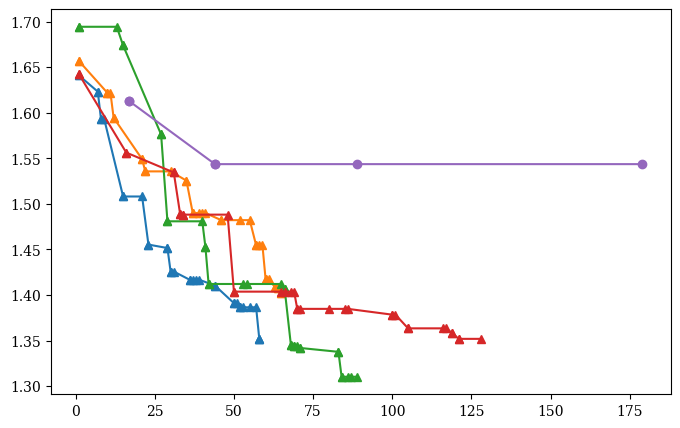

In [27]:
plot_all(k_table)